# Floodscan vs. CHIRPS

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import datetime

import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import numpy as np
import rioxarray as rxr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.datasources import codab, chirps, floodscan
from src.constants import *

In [3]:
# floodscan.calculate_adm2_daily_rasterstats()

In [4]:
adm = codab.load_codab(admin_level=2, aoi_only=True)

In [5]:
fs = floodscan.load_adm2_daily_rasterstats()
rolls = [1, 3, 5, 7, 9, 11]
for roll in rolls:
    fs[f"fs_roll{roll}"] = (
        fs.groupby("ADM2_PCODE")["SFED_AREA"]
        .transform(lambda x: x.rolling(window=roll, min_periods=roll).mean())
        .shift(-np.floor(roll / 2).astype(int))
    )

In [6]:
ch = chirps.load_raster_stats()

ch = ch.rename(columns={"T": "time"})
ch = ch.sort_values("time")

rolls = [1, 2, 3, 5, 7, 10, 15, 20, 30, 60, 90]
for roll in rolls:
    ch[f"ch_roll{roll}"] = ch.groupby("ADM2_PCODE")["mean"].transform(
        lambda x: x.rolling(window=roll, min_periods=roll).mean()
    )

In [7]:
compare = fs.merge(ch, on=["ADM2_PCODE", "time"])
compare_seasonal = (
    compare.groupby(["ADM2_PCODE", compare["time"].dt.dayofyear])
    .mean()
    .drop(columns="time")
    .reset_index()
    .rename(columns={"time": "dayofyear"})
)
compare_seasonal["date_2000"] = pd.Timestamp("2000-01-01") + pd.to_timedelta(
    compare_seasonal["dayofyear"] - 1, unit="d"
)

In [8]:
compare_peak = compare.copy().iloc[
    compare.groupby(["ADM2_PCODE", compare["time"].dt.year])[
        "fs_roll7"
    ].idxmax()
]
compare_peak["year"] = compare_peak["time"].dt.year

In [9]:
peak_corr = compare_peak.groupby("ADM2_PCODE").corr()
peak_corr = peak_corr[
    [x for x in peak_corr.columns if "ch_roll" in x]
].reset_index()
peak_corr = peak_corr[peak_corr["level_1"] == "fs_roll7"].drop(
    columns="level_1"
)
peak_corr

,ADM2_PCODE,ch_roll1,ch_roll2,ch_roll3,ch_roll5,ch_roll7,ch_roll10,ch_roll15,ch_roll20,ch_roll30,ch_roll60,ch_roll90
5,NG002001,-0.181432,0.050728,-0.155301,-0.028854,0.113583,0.069381,0.211689,0.117425,0.055645,0.200196,0.193709
26,NG002002,0.041361,0.234830,0.177734,0.240883,0.320579,0.308309,0.264360,0.258457,-0.005584,0.014453,0.024997
47,NG002003,-0.061664,-0.034713,-0.104301,-0.110458,-0.233421,-0.191563,0.019502,0.011199,-0.100355,-0.093244,-0.086978
68,NG002004,-0.075379,0.267824,0.185333,0.161877,0.100729,0.146008,0.245660,0.227566,0.193166,0.150810,0.104060
89,NG002005,0.046307,0.182200,0.200488,0.273942,0.197277,0.206094,0.332321,0.285154,0.310623,0.357516,0.339866
...,...,...,...,...,...,...,...,...,...,...,...,...
1244,NG036013,0.650379,0.457035,0.623859,0.438046,0.565354,0.546889,0.535403,0.517753,0.464265,0.384839,0.267261
1265,NG036014,0.408743,0.196243,0.242484,0.390527,0.434297,0.371410,0.318658,0.290839,0.304627,0.296725,0.248478
1286,NG036015,-0.078096,-0.136662,-0.096514,-0.155344,-0.120633,-0.179880,-0.201951,-0.215319,-0.231234,-0.244962,-0.259365
1307,NG036016,-0.198749,-0.254395,-0.242504,-0.233982,-0.216885,-0.214796,-0.160013,-0.169016,-0.097398,0.292799,0.684308


<Axes: xlabel='time'>

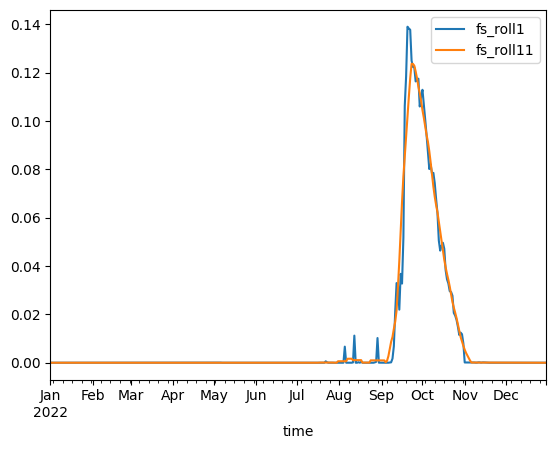

In [10]:
year = 2022
pcode = JAKUSKO
compare[
    (compare["time"].dt.year == year) & (compare["ADM2_PCODE"] == pcode)
].set_index("time")[["fs_roll1", "fs_roll11"]].plot()

(9.407073060800041, 14.929851623200069, 7.061896598600024, 14.030824463400043)

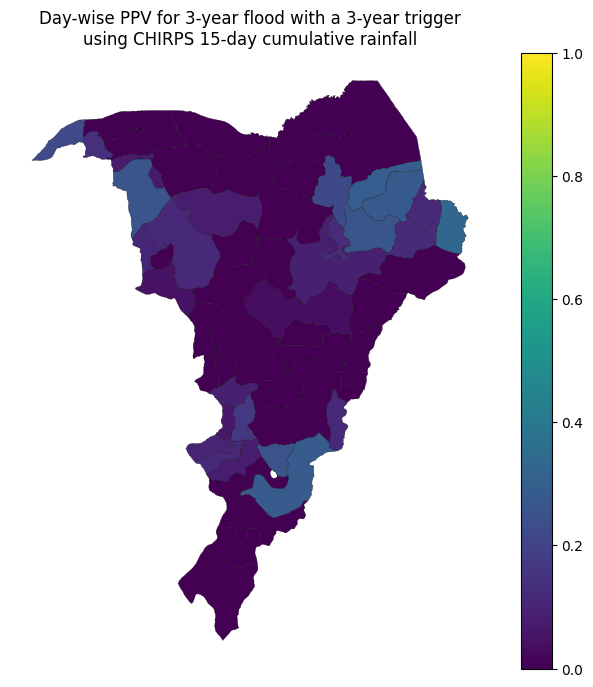

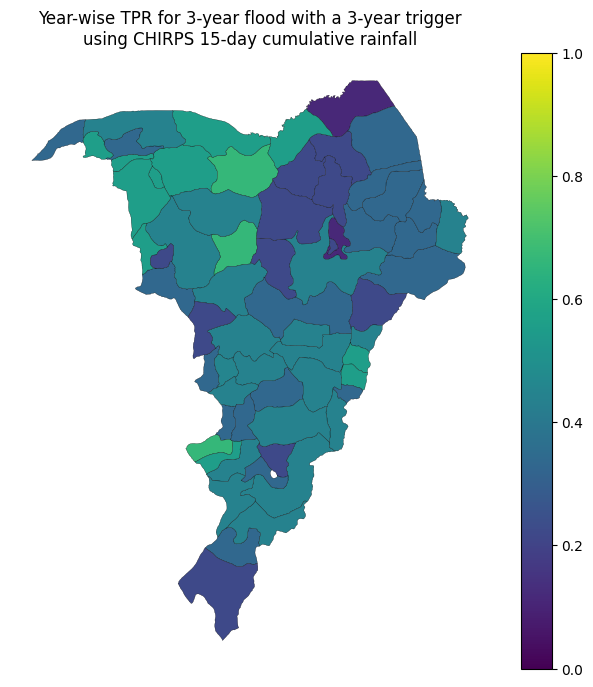

In [11]:
ch_rp = 3
fs_rp = 3

roll_fs = 7
roll_ch = 15
fs_col = f"fs_roll{roll_fs}"
ch_col = f"ch_roll{roll_ch}"


def calc_P_PP(group):
    maxes = group.groupby(group["time"].dt.year).max(numeric_only=True)
    group["PP"] = group[ch_col] >= maxes[ch_col].quantile(q=1 - 1 / ch_rp)
    group["P"] = group[fs_col] >= maxes[fs_col].quantile(q=1 - 1 / fs_rp)
    return group


compare = (
    compare.groupby("ADM2_PCODE")
    .apply(calc_P_PP, include_groups=False)
    .reset_index()
    .drop(columns="level_1")
)


def calc_TP(df):
    df["TP"] = df["P"] & df["PP"]
    df["FP"] = df["PP"] & ~df["P"]
    df["FN"] = ~df["PP"] & df["P"]
    df["TN"] = ~df["PP"] & ~df["P"]
    df["N"] = ~df["P"]
    df["PN"] = ~df["PP"]
    return df


compare = calc_TP(compare)


def calc_metrics(df):
    sums = df.sum(numeric_only=True)
    return pd.Series(
        {
            "TPR": sums["TP"] / sums["P"],
            "PPV": sums["TP"] / sums["PP"],
            "TNR": sums["TN"] / sums["N"],
            "FPR": sums["FP"] / sums["N"],
            "FNR": sums["FN"] / sums["P"],
        }
    )


metrics = (
    compare.groupby("ADM2_PCODE")
    .apply(calc_metrics, include_groups=False)
    .reset_index()
)

compare_year = (
    compare.groupby(["ADM2_PCODE", compare["time"].dt.year])[["P", "PP"]]
    .any()
    .reset_index()
)
compare_year = calc_TP(compare_year)

metrics_year = (
    compare_year.groupby("ADM2_PCODE")
    .apply(calc_metrics, include_groups=False)
    .reset_index()
)

metric = "PPV"
fig, ax = plt.subplots(figsize=(8, 8))
adm.merge(metrics, on="ADM2_PCODE").plot(
    column=metric,
    vmin=0,
    vmax=1,
    legend=True,
    # cmap="Blues",
    edgecolor="k",
    linewidth=0.2,
    ax=ax,
)
ax.set_title(
    f"Day-wise {metric} for {fs_rp}-year flood with a {ch_rp}-year trigger\n"
    f"using CHIRPS {roll_ch}-day cumulative rainfall"
)
ax.axis("off")

fig, ax = plt.subplots(figsize=(8, 8))
adm.merge(metrics_year, on="ADM2_PCODE").plot(
    column="TPR",
    vmin=0,
    vmax=1,
    legend=True,
    # cmap="Blues",
    edgecolor="k",
    linewidth=0.2,
    ax=ax,
)
ax.set_title(
    f"Year-wise TPR for {fs_rp}-year flood with a {ch_rp}-year trigger\n"
    f"using CHIRPS {roll_ch}-day cumulative rainfall"
)
ax.axis("off")

In [12]:
for pcode in ALL_PRIORITY_ADM2_PCODES:
    print(adm.groupby("ADM2_PCODE").first().loc[pcode, "ADM2_EN"])
    print(metrics_year.set_index("ADM2_PCODE").loc[pcode])

Bama
TPR    0.333333
PPV    0.333333
TNR    0.647059
FPR    0.352941
FNR    0.666667
Name: NG008003, dtype: float64
Numan
TPR    0.555556
PPV    0.555556
TNR    0.764706
FPR    0.235294
FNR    0.444444
Name: NG002016, dtype: float64
Dikwa
TPR    0.333333
PPV    0.333333
TNR    0.647059
FPR    0.352941
FNR    0.666667
Name: NG008008, dtype: float64
Ngala
TPR    0.333333
PPV    0.333333
TNR    0.647059
FPR    0.352941
FNR    0.666667
Name: NG008025, dtype: float64


(9.407073060800041, 14.929851623200069, 7.061896598600024, 14.030824463400043)

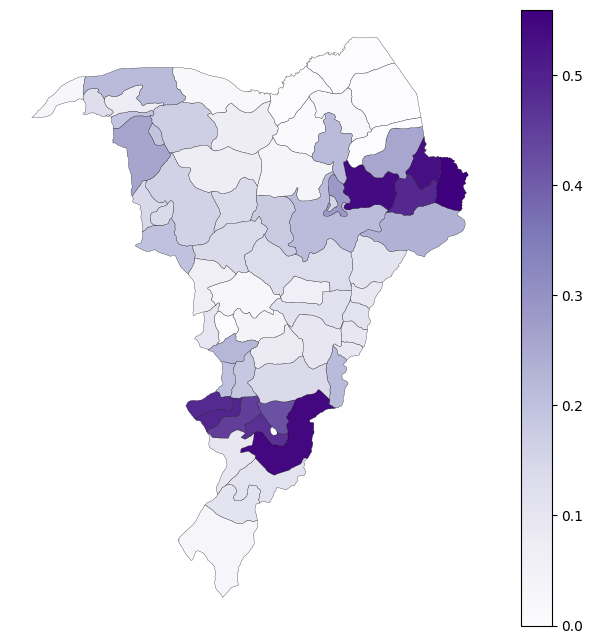

In [13]:
fs_roll = 7

corr = compare.groupby("ADM2_PCODE").corr()
corr = (
    corr[[x for x in corr.columns if "fs_roll" in x]]
    .reset_index()
    .rename(columns={"level_1": "ch_roll"})
)
corr = corr[corr["ch_roll"].str.contains("ch_roll")]
corr = corr.melt(
    id_vars=["ADM2_PCODE", "ch_roll"],
    value_vars=[x for x in corr.columns if "fs_roll" in x],
    value_name="corr",
    var_name="fs_roll",
)
corr["ch_roll"] = corr["ch_roll"].str.removeprefix("ch_roll").astype(int)
corr["fs_roll"] = corr["fs_roll"].str.removeprefix("fs_roll").astype(int)
corr = corr[corr["fs_roll"] == fs_roll]

ch_roll_max = 30
corr_max = corr.loc[
    corr[corr["ch_roll"] <= ch_roll_max].groupby("ADM2_PCODE")["corr"].idxmax()
]
corr_max = corr_max.sort_values("corr", ascending=False)

fig, ax = plt.subplots(figsize=(8, 8))
adm.merge(corr_max, on="ADM2_PCODE").plot(
    column="corr",
    vmin=0,
    legend=True,
    cmap="Purples",
    edgecolor="k",
    linewidth=0.2,
    ax=ax,
)
ax.axis("off")

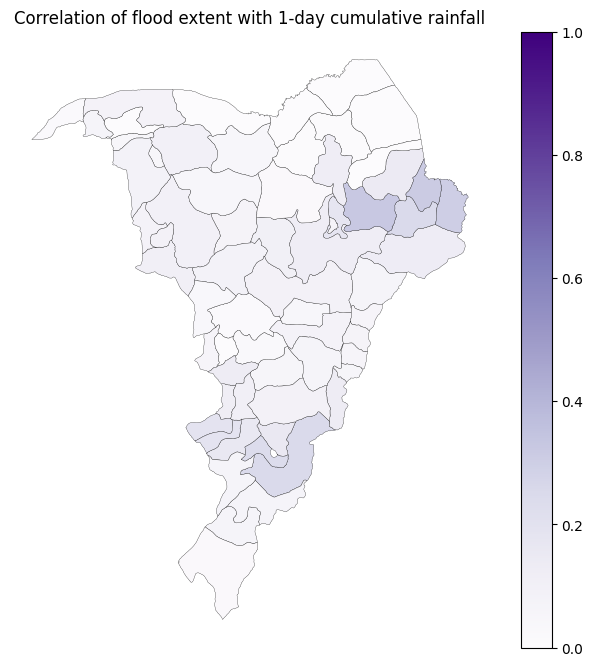

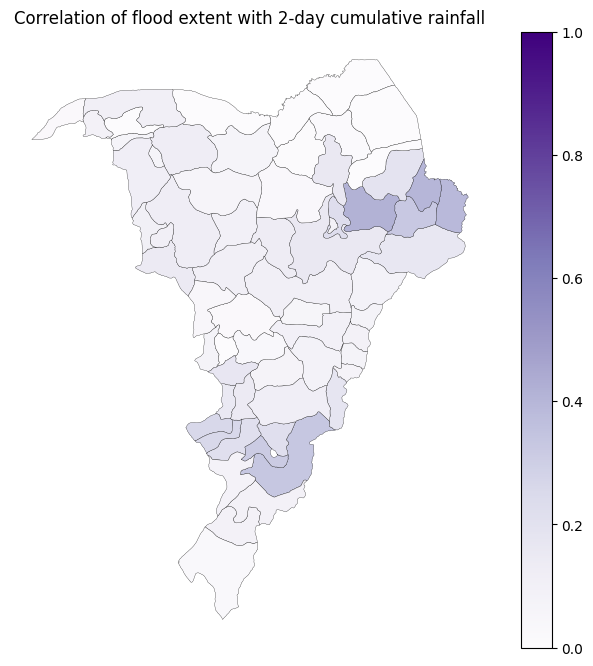

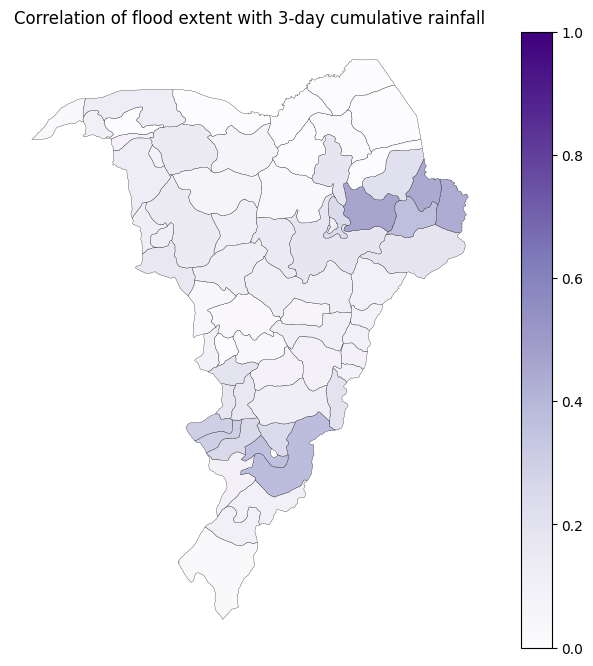

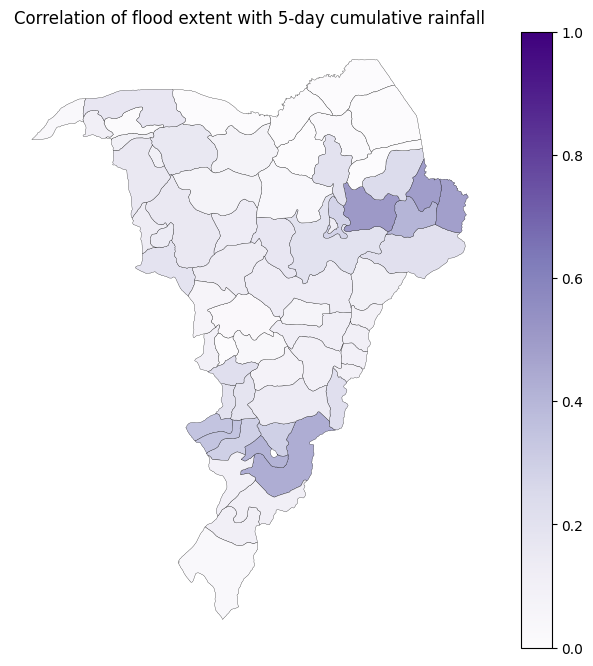

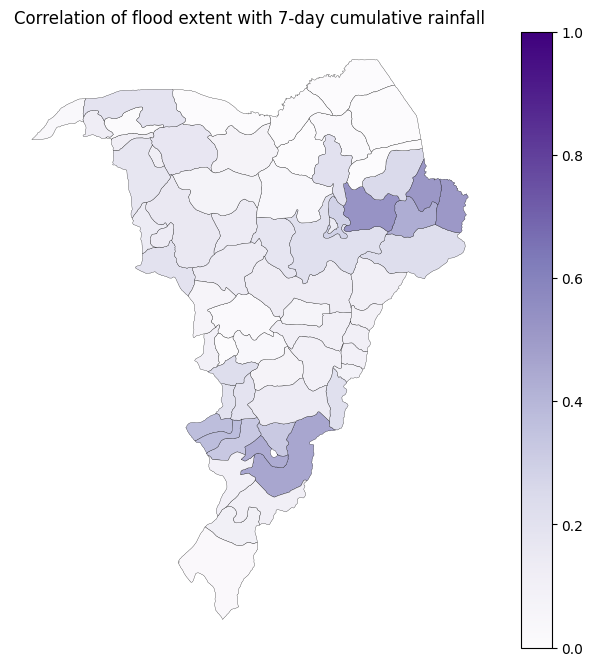

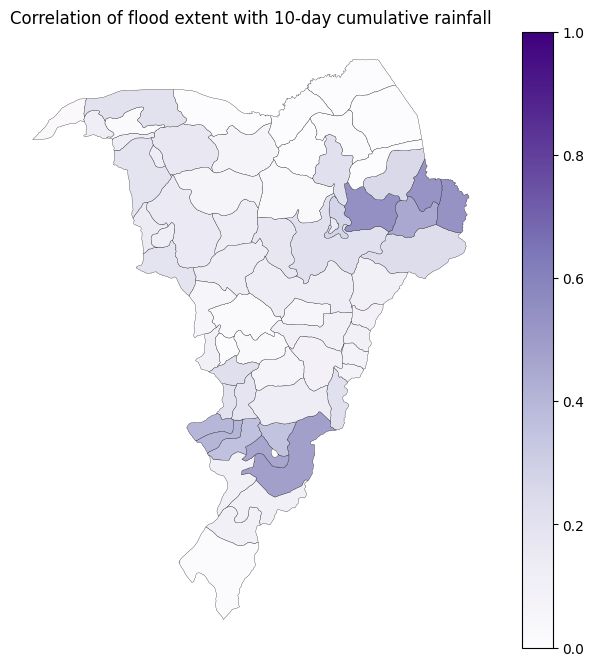

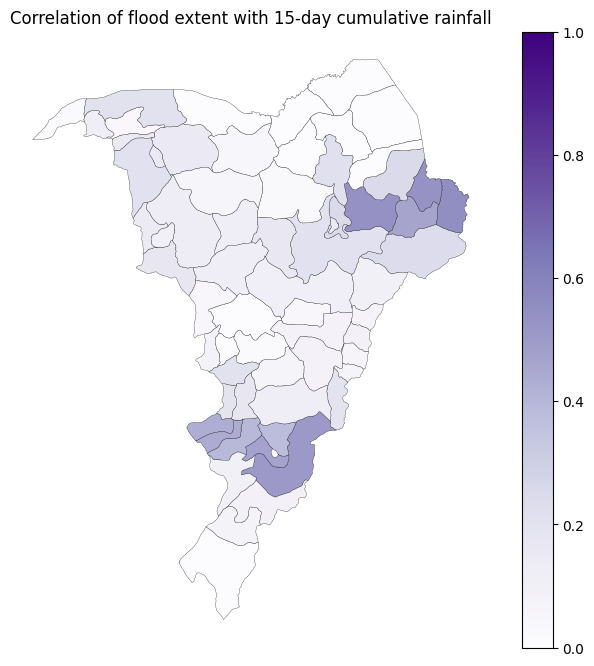

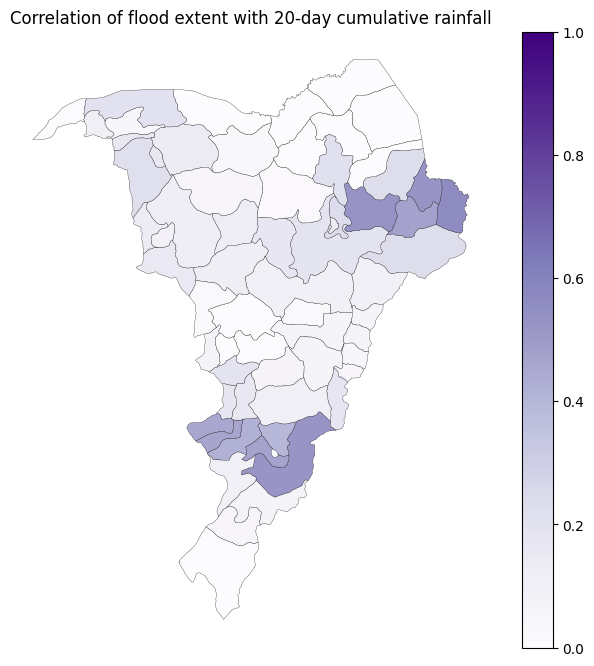

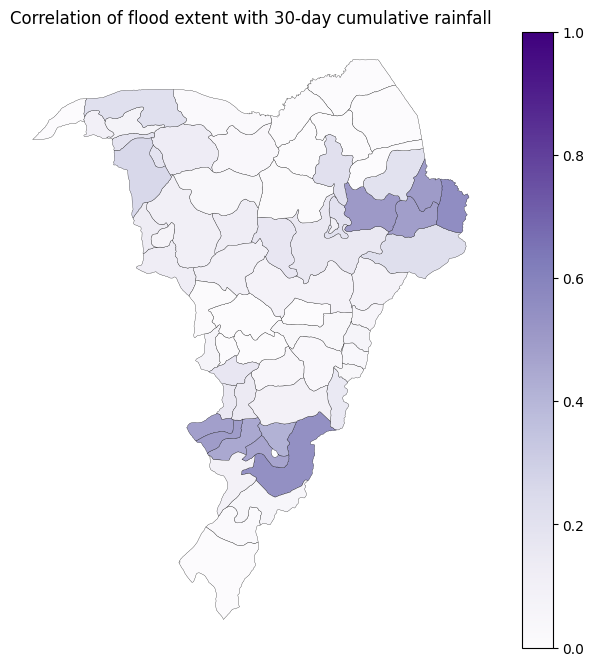

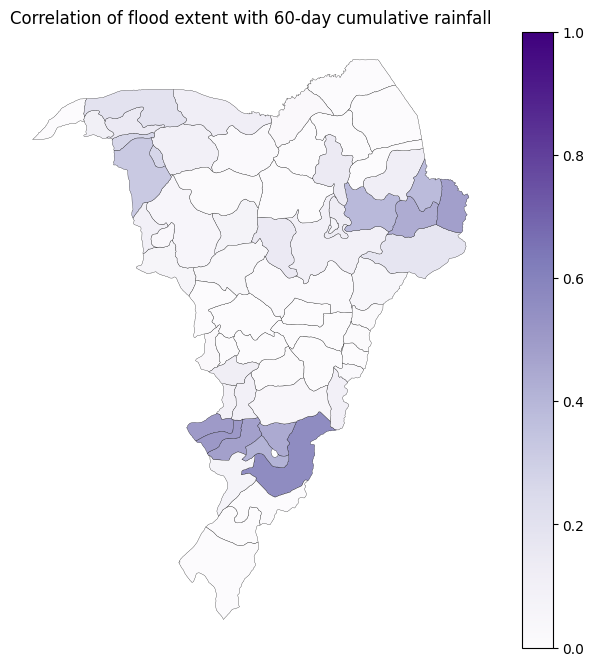

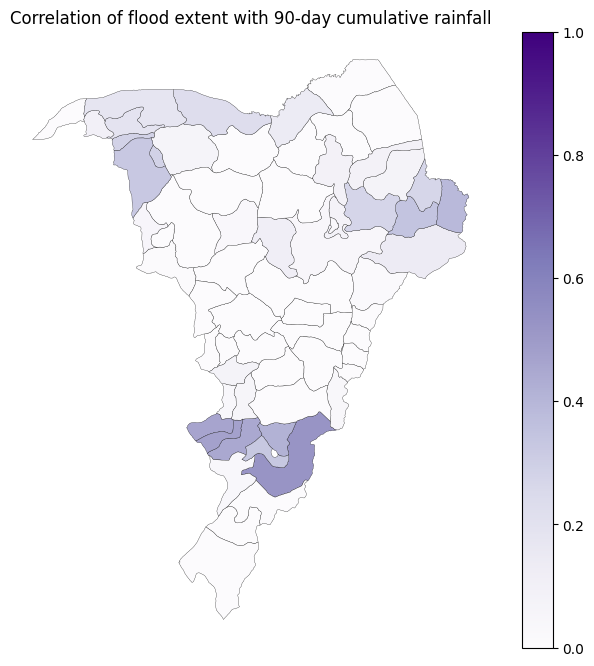

In [14]:
for ch_roll, group in corr.groupby("ch_roll"):
    fig, ax = plt.subplots(figsize=(8, 8))
    adm.merge(group, on="ADM2_PCODE").plot(
        column="corr",
        vmin=0,
        vmax=1,
        legend=True,
        cmap="Purples",
        edgecolor="k",
        linewidth=0.2,
        ax=ax,
    )
    ax.axis("off")
    ax.set_title(
        f"Correlation of flood extent with {ch_roll}-day cumulative rainfall"
    )

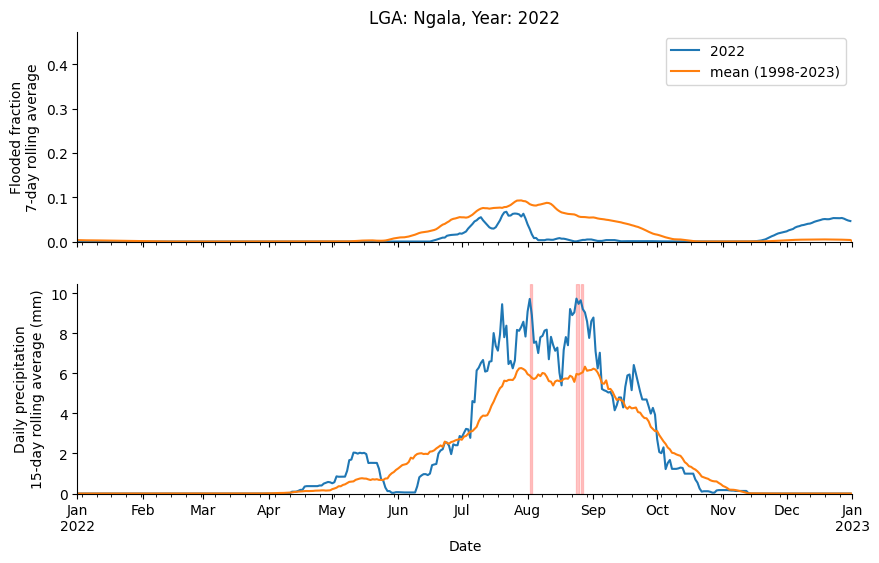

In [15]:
pcode = NGALA
admin2_name = adm[adm["ADM2_PCODE"] == pcode]["ADM2_EN"].iloc[0]
roll_fs = 7
roll_ch = 15
fs_max = compare[compare["ADM2_PCODE"] == pcode][f"fs_roll{roll_fs}"].max()
ch_max = compare[compare["ADM2_PCODE"] == pcode][f"ch_roll{roll_ch}"].max()


# for year in compare["time"].dt.year.unique():
for year in [2022]:
    compare_f = compare[
        (compare["time"].dt.year == year) & (compare["ADM2_PCODE"] == pcode)
    ]
    compare_seasonal_f = compare_seasonal[
        compare_seasonal["ADM2_PCODE"] == pcode
    ].copy()

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
    compare_f.plot(x="time", y=f"fs_roll{roll_fs}", label=year, ax=axs[0])
    compare_seasonal_f["date_dummy"] = pd.Timestamp(
        f"{year}-01-01"
    ) + pd.to_timedelta(compare_seasonal_f["dayofyear"] - 1, unit="d")

    compare_seasonal_f.plot(
        x="date_dummy",
        y=f"fs_roll{roll_fs}",
        ax=axs[0],
        label="mean (1998-2023)",
    )
    for index, row in compare_f.set_index("time").iterrows():
        if row["P"]:
            axs[0].axvspan(
                index, index + pd.Timedelta(days=1), color="red", alpha=0.2
            )
        if row["PP"]:
            axs[1].axvspan(
                index, index + pd.Timedelta(days=1), color="red", alpha=0.2
            )

    axs[0].set_ylabel(f"Flooded fraction\n{roll_fs}-day rolling average")
    axs[0].set_ylim(bottom=0, top=fs_max)

    compare_f.plot(
        x="time", y=f"ch_roll{roll_ch}", ax=axs[1], label=year, legend=False
    )

    compare_seasonal_f.plot(
        x="date_dummy",
        y=f"ch_roll{roll_ch}",
        ax=axs[1],
        label="mean (1998-2023)",
        legend=False,
    )

    axs[1].set_ylabel(
        f"Daily precipitation\n{roll_ch}-day rolling average (mm)"
    )
    axs[1].set_ylim(bottom=0, top=ch_max)

    for ax in axs:
        ax.set_xlabel("Date")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    axs[0].set_title(f"LGA: {admin2_name}, Year: {year}")